In [1]:
import torch
import torch.nn.functional as F


torch.manual_seed(12046)

# 批归一化
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        # 用于处理方差等于0的极端情况
        self.eps = eps
        # 模型参数
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # 用于表示是否在模型训练阶段
        self.training = True
        # 用于预估所有数据的期望的方差
        self.momentum = momentum
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
 
    def __call__(self, x):
        if self.training:
            # 计算期望和方差
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=False)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # 归一化处理
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [2]:
from utils import Linear, Tanh, Sequential
import matplotlib.pyplot as plt
%matplotlib inline


# 在模型中加入归一化层
n_hidden = 100
model = Sequential([
    Linear(       2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(       n_hidden, 2, bias=False)
    ])

In [3]:
# 参数初始化优化
with torch.no_grad():
    for layer in model.layers:
        if isinstance(layer, Linear):
            in_features, out_features = layer.weight.shape
            # 将权重项的方差变小
            layer.weight *= 1 / in_features ** 0.5
            
# 对于模型参数，需要记录它们的梯度（为反向传播做准备）
for p in model.parameters():
    p.requires_grad = True

In [4]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import numpy as np


np.random.seed(12046)
data = make_moons(n_samples=2000, noise=.05)
scaler = StandardScaler()
data = (scaler.fit_transform(data[0]), data[1])

In [5]:
def train_model(max_steps):
    batch_size = 2000
    lossi = []
    udi = {}
    x, y = torch.tensor(data[0]).float(), torch.tensor(data[1])
    _prob = torch.ones(x.shape[0]) / x.shape[0]

    for i in range(max_steps):
        # 构造批次训练数据
        ## 不放回的随机抽样
        ix = _prob.multinomial(batch_size)
        xb = x[ix]
        yb = y[ix]
        # 向前传播
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        # 保留中间节点的梯度，以便观察
        for layer in model.layers:
            layer.out.retain_grad()
        for p in model.parameters():
            p.grad = None
        # 反向传播
        loss.backward()
        # 更新模型参数
        ## 学习速率衰减
        learning_rate = 0.01 if i < 500 else 1
        with torch.no_grad():
            for i, p in enumerate(model.parameters()):
                p -= learning_rate * p.grad
                udi[i] = udi.get(i, []) + [(learning_rate * p.grad).std() / p.std()]
        lossi.append(loss.item())
    return lossi, udi

In [6]:
train_model(1)

([0.9243127107620239],
 {0: [tensor(0.0018)],
  1: [tensor(1.0000)],
  2: [tensor(1.)],
  3: [tensor(0.0067)],
  4: [tensor(1.0000)],
  5: [tensor(1.)],
  6: [tensor(0.0046)],
  7: [tensor(1.0000)],
  8: [tensor(1.)],
  9: [tensor(0.0034)],
  10: [tensor(1.0000)],
  11: [tensor(1.)],
  12: [tensor(0.0241)]})

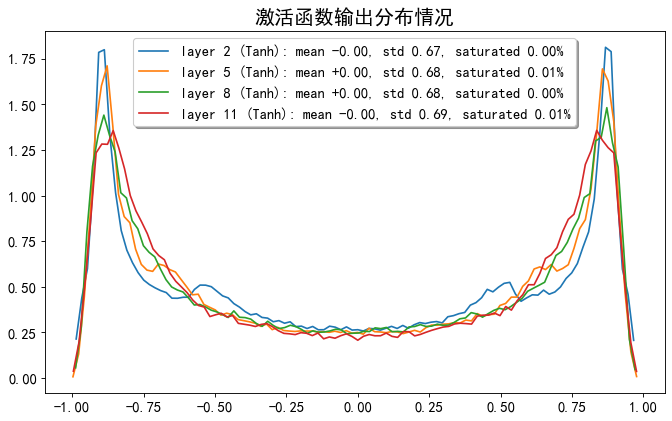

In [7]:
# 观察激活函数的状态
plt.figure(figsize=(10, 6), dpi=80)
# 解决中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 13})
legends = []
for i, layer in enumerate(model.layers):
    if isinstance(layer, (Tanh)):
        t = layer.out
        # 激活函数的输出大于0.99时，激活函数“过热”
        saturation = (t.abs() > 0.99).float().mean()
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        layer_name = f'layer {i} ({layer.__class__.__name__})'
        stats = f'mean {t.mean():+.2f}, std {t.std():.2f}, saturated {saturation:.2%}'
        legends.append(f'{layer_name}: {stats}')
plt.legend(legends, shadow=True)
plt.title('激活函数输出分布情况', fontsize=18)
plt.show()

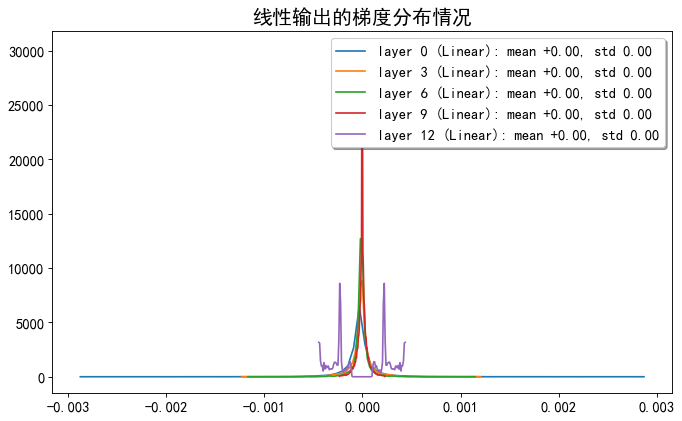

In [8]:
plt.figure(figsize=(10, 6), dpi=80)
# 解决中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 13})
legends = []
for i, layer in enumerate(model.layers):
    if isinstance(layer, (Linear)):
        t = layer.out.grad
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        layer_name = f'layer {i} ({layer.__class__.__name__})'
        stats = f'mean {t.mean():+.2f}, std {t.std():.2f}'
        legends.append(f'{layer_name}: {stats}')
plt.legend(legends, shadow=True)
plt.title('线性输出的梯度分布情况', fontsize=18)
plt.show()

layer 0   (2, 100): mean -0.0019, std 0.1262, grad ratio 0.17823945
layer 3 (100, 100): mean -0.0004, std 0.0667, grad ratio 0.67149943
layer 6 (100, 100): mean -0.0001, std 0.0461, grad ratio 0.46003518
layer 9 (100, 100): mean +0.0004, std 0.0336, grad ratio 0.33972958


Text(0.5, 1.0, '权重参数的梯度分布情况')

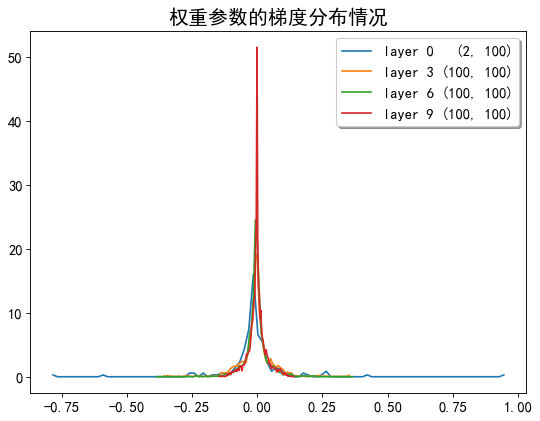

In [9]:
# 观察参数梯度的分布情况
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(111)
legends = []
# 输出层的参数较为特殊，这里在作图时排除掉
for i, layer in enumerate(model.layers[:-1]):
    if isinstance(layer, (Linear)):
        # 只观察权重参数，也就是w
        p = layer.parameters()[0]
        g = p.grad
        # 统计梯度标准差与参数标准差的比例
        grad_ratio = g.std() / p.std()
        hy, hx = torch.histogram(g, density=True)
        ax.plot(hx[:-1].detach(), hy.detach())
        layer_name = f'layer {i} {str(tuple(p.shape)):>10}'
        stats = f'mean {g.mean():+.4f}, std {g.std():.4f}, grad ratio {grad_ratio:.8f}'
        legends.append(f'{layer_name}')
        print(f'{layer_name}: {stats}')
ax.legend(legends, shadow=True)
ax.set_title('权重参数的梯度分布情况', fontsize=18)

In [10]:
_, ud = train_model(1000)

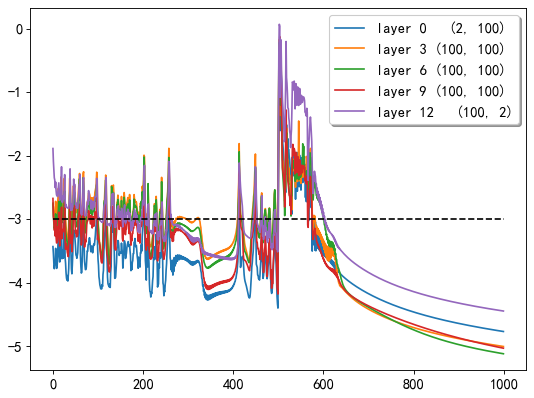

In [11]:
plt.figure(figsize=(8, 6), dpi=80)
legends = []
for i, p in enumerate(model.parameters()):
    # 只观察权重参数，也就是w
    if p.ndim == 2:
        plt.plot([t.log10().item() for t in ud[i]])
        legends.append(f'layer {i} {str(tuple(p.shape)):>10}')
# 理想的标准线
plt.plot([0, len(ud[0])], [-3, -3], 'k--')
plt.legend(legends, shadow=True)
plt.show()

In [12]:
@torch.no_grad()
def layer_stats(func):
    """
    只做向前传播，并记录每一层输出的分布情况
    理想情况下，各层输出的方差应该保持稳定
    参数
    ----
    func : 激活函数
    """
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = fig.add_subplot(111)
    legends = []
    x = torch.randn(300, 1000)  # 批量大小是300
    for i in range(10):
        l = Linear(1000, 1000, bias=False)
        b = BatchNorm1d(1000)
        in_features, _ = l.weight.shape
        # 做初步的优化
        l.weight *= 1 / in_features ** 0.5
        # 使用归一化层做进一步优化
        x = func(b(l(x)))
        # 记录输出的分布情况
        hy, hx = torch.histogram(x, density=True)
        ax.plot(hx[:-1].detach(), hy.detach())
        layer_name = f'layer {str(i + 1):>2}'
        stats = f'mean {x.mean().item():+.2f}, std {x.std().item():.2f}'
        print (f'{layer_name}: {stats}')
        legends.append(f'{layer_name}: {stats}')
    return fig, legends

layer  1: mean -0.00, std 0.63
layer  2: mean +0.00, std 0.63
layer  3: mean -0.00, std 0.63
layer  4: mean -0.00, std 0.63
layer  5: mean -0.00, std 0.63
layer  6: mean +0.00, std 0.63
layer  7: mean +0.00, std 0.63
layer  8: mean +0.00, std 0.63
layer  9: mean +0.00, std 0.63
layer 10: mean +0.00, std 0.63


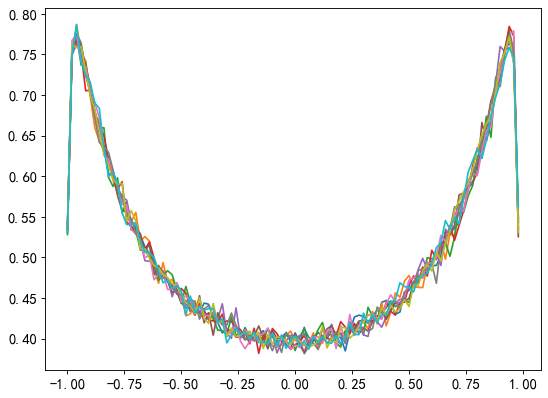

In [13]:
fig, legends = layer_stats(torch.tanh)

layer  1: mean +0.40, std 0.58
layer  2: mean +0.40, std 0.58
layer  3: mean +0.40, std 0.58
layer  4: mean +0.40, std 0.58
layer  5: mean +0.40, std 0.58
layer  6: mean +0.40, std 0.59
layer  7: mean +0.40, std 0.58
layer  8: mean +0.40, std 0.58
layer  9: mean +0.40, std 0.58
layer 10: mean +0.40, std 0.58


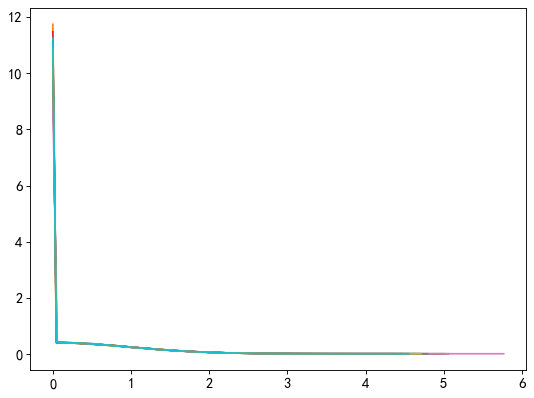

In [14]:
fig, legends = layer_stats(torch.relu)